In [1]:
import random
import json
import pickle
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Additional imports for word tokenization and padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the WordNet lemmatizer

lemmatizer = WordNetLemmatizer()

# Load the intents file
with open('intents.json') as file:
    intents = json.load(file)

[nltk_data] Downloading package punkt to C:\Users\M
[nltk_data]     Venkatesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\M
[nltk_data]     Venkatesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:

# Extract words, classes, and documents from intents
words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']

for intent in intents['intents']:
    for pattern in intent['patterns']:
        word_list = nltk.word_tokenize(pattern)
        words.extend(word_list)
        documents.append((word_list, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

# Lemmatize and lowercase each word, remove duplicates, and sort
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

# Save preprocessed words and classes using pickle
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))


In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import random

training = []  # To store the training data
output_empty = [0] * len(classes)  # Empty array to represent the output for each class

for document in documents:
    bag = []  # Bag of words representation for each pattern
    word_patterns = document[0]
    word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns if word.lower() not in ignore_letters]

    # Create bag of words for each pattern
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)

    # Reuse and reset output_row for efficiency
    output_row = output_empty.copy()  # Create a copy to avoid modifying original list
    output_row[classes.index(document[1])] = 1

    # Add the bag of words and one-hot encoded output to training data
    training.append([bag, output_row])

# Shuffle the training data
random.shuffle(training)

# Pad input sequences to ensure consistent length
max_len = max(len(bag) for bag, _ in training)
train_x = [bag for bag, _ in training]
train_x = pad_sequences(train_x, maxlen=max_len, padding='post')

# Convert output labels to NumPy array
train_y = np.array([label for _, label in training])

# Convert lists to NumPy arrays
train_x = np.array(train_x)

# Split training data into input (X) and output (Y)
train_y = np.array(train_y)

# Ensure train_x has the right shape
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))

# Print shapes to verify
print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)


Train X shape: (85, 137, 1)
Train Y shape: (85, 16)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD

# Define the model architecture
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))  # Input layer with 128 neurons and ReLU activation function
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(Dense(64, activation='relu'))  # Hidden layer with 64 neurons and ReLU activation function
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(Dense(len(train_y[0]), activation='softmax'))  # Output layer with softmax activation function for multiclass classification

# Compile the model
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)  # Stochastic Gradient Descent optimizer
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train the model
history = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)

# Save the trained model
model.save('chatbot_model.h5')
print('Model trained and saved successfully!')


Epoch 1/200
17/17 [==============================] - 2s 4ms/step - loss: 2.7663 - accuracy: 0.0706
Epoch 2/200
17/17 [==============================] - 0s 4ms/step - loss: 2.7644 - accuracy: 0.0588
Epoch 3/200
17/17 [==============================] - 0s 3ms/step - loss: 2.7294 - accuracy: 0.1176
Epoch 4/200
17/17 [==============================] - 0s 5ms/step - loss: 2.6257 - accuracy: 0.1529
Epoch 5/200
17/17 [==============================] - 0s 3ms/step - loss: 2.5510 - accuracy: 0.2118
Epoch 6/200
17/17 [==============================] - 0s 3ms/step - loss: 2.4308 - accuracy: 0.2588
Epoch 7/200
17/17 [==============================] - 0s 3ms/step - loss: 2.2852 - accuracy: 0.2824
Epoch 8/200
17/17 [==============================] - 0s 3ms/step - loss: 2.2482 - accuracy: 0.2588
Epoch 9/200
17/17 [==============================] - 0s 3ms/step - loss: 2.2372 - accuracy: 0.2471
Epoch 10/200
17/17 [==============================] - 0s 2ms/step - loss: 2.0418 - accuracy: 0.3059
Epoch 11/

C:\Users\M Venkatesh\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model trained and saved successfully!


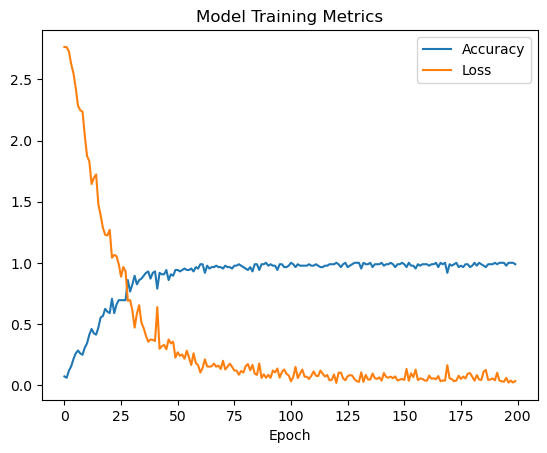

Word and class dictionaries saved successfully!


In [5]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Training Metrics')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper right')
plt.show()

# Save the word and class dictionaries for later use
import pickle

with open('words.pkl', 'wb') as file:
    pickle.dump(words, file)

with open('classes.pkl', 'wb') as file:
    pickle.dump(classes, file)

print('Word and class dictionaries saved successfully!')


In [6]:
import json

# Open the JSON file
with open('intents.json', 'r') as file:
    intents_data = json.load(file)

# Now you can access the data in the JSON file
print(intents_data)


{'intents': [{'tag': 'greetings', 'patterns': ['hello', 'hey', 'hi', 'good day', 'greetings', "what's up?", 'how is it going'], 'responses': ['hello', 'hey!', 'what can i do for you?']}, {'tag': 'goodbye', 'patterns': ['cya', 'see you later', 'goodbye', 'have a good day', 'bye', 'cao', 'see ya'], 'responses': ['Yep!! Have a nice day', 'goodbye']}, {'tag': 'age', 'patterns': ['how old', 'how old are you?', 'what is your age', 'how old are you', 'age?'], 'responses': ['I get reborn after every compilation', 'hey!', 'my owners are averagely 20 years!']}, {'tag': 'question', 'patterns': ["how can you help me?', 'how can you guide me"], 'responses': ['I am a healthcare chatbot. I can assist you with medical information and advice.']}, {'tag': 'name', 'patterns': ['what is your name', 'what should i call you', "what's your name?", 'who are you?', 'can you tell me your name'], 'responses': ['you can call me Medbot!', 'i am Medbot!', 'i am Medbot your medical assistant']}, {'tag': 'common cold

In [7]:
# Assuming your model is named 'model'
input_shape = model.input_shape
actual_length = input_shape[1]  # Assuming the input length is the second dimension

print("Actual input length:", actual_length)


Actual input length: 137


In [8]:
import tkinter as tk
from tkinter import scrolledtext
import random
import numpy as np
import nltk
import pickle
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('chatbot_model.h5')

# Load the words and classes
with open('words.pkl', 'rb') as file:
    words = pickle.load(file)
with open('classes.pkl', 'rb') as file:
    classes = pickle.load(file)

# Initialize the WordNet lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

# Function to preprocess the user input
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

# Function to create bag of words from the input sentence
def bow(sentence, words):
    sentence_words = clean_up_sentence(sentence)
    bag = [0]*len(words)
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s:
                bag[i] = 1
    return np.array(bag)

def get_response(user_input):
    # Preprocess the input
    bow_input = bow(user_input, words)
    # Predict the class label
    result = model.predict(np.array([bow_input]))[0]
    # Get the index of the highest probability
    predicted_class_index = np.argmax(result)
    # Get the corresponding class label
    predicted_class = classes[predicted_class_index]
    
    # Filter out responses for the predicted class
    for intent in intents['intents']:
        if intent['tag'] == predicted_class:
            responses = intent['responses']
            break  
    else:
        # If no matching intent found, return a default response
        responses = ["I'm sorry, I didn't understand that. Can you please rephrase or ask a different question?"]
    
    # Return a random response from the list
    return random.choice(responses)


# Create a Tkinter window
root = tk.Tk()
root.title("Healthcare Chatbot")

# Create a scrolled text widget for chat display
chat_box = scrolledtext.ScrolledText(root, wrap=tk.WORD, width=80, height=30)
chat_box.grid(column=0, row=0, padx=10, pady=10) 


# Function to handle sending messages
def send_message():
    user_input = entry_box.get()
    entry_box.delete(0, tk.END)
    chat_box.insert(tk.END, "You: " + user_input + '\n')
    # Generate and display the bot's response
    bot_response = get_response(user_input)
    chat_box.insert(tk.END, "Bot: " + bot_response + '\n\n')

# Create an entry box for user input
entry_box = tk.Entry(root, width=80)
entry_box.grid(column=0, row=1, padx=10, pady=10)

# Create a button to send messages
send_button = tk.Button(root, text="Send", command=send_message, width=10, height=2)
send_button.grid(column=1, row=1, padx=10, pady=10)

# Start the Tkinter event loop
root.mainloop()


1/1 [==============================] - 0s 21ms/step
